<a href="https://colab.research.google.com/github/vinay0703/fyp-minor/blob/main/Simulation_codebase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
Y_train = np.zeros((5*250,3))
Y_val = np.zeros((5*250,3))
for i in range(0,5) :
  Y_train[250*i:250*(i+1), :] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i+1))).T[3:253,:]
  Y_val[250*i:250*(i+1), :] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i+1+5))).T[3:253,:]

In [4]:
X_train = np.zeros((250*5,4,128,128,3))
X_val = np.zeros((250*5,4,128,128,3))
def get_X(i) :
  X = np.zeros((250,4,128,128,3))
  vidcap = cv2.VideoCapture('gdrive/My Drive/FYP-Data/Scenes Videos/{}/Basic _FirstMP4.mp4'.format(i))
  count = 1
  k = 0
  while count<250 :  
    if k == 0 :
      while k < 4 :
        success, image = vidcap.read()
        img = cv2.resize(image, (128, 128))
        X[count-1,k,:,:,:] = np.copy(img)
        k += 1
    else :
      X[count-1,0:3,:,:,:] = np.copy(X[count-2,1:4,:,:,:])
      success, image = vidcap.read()
      img = cv2.resize(image, (128, 128))
      X[count-1,3,:,:,:] = np.copy(img)
    count += 1
  return X
for i in range(0,5) :
  print(i)
  X_train[250*i:250*(i+1),:,:,:] = get_X(i+1)
  X_val[250*i:250*(i+1),:,:,:] = get_X(i+1+5)

0
1
2
3
4


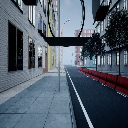

In [5]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_train[0,0,:,:,:])

In [6]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(1250, 4, 128, 128, 3) (1250, 3)
(1250, 4, 128, 128, 3) (1250, 3)


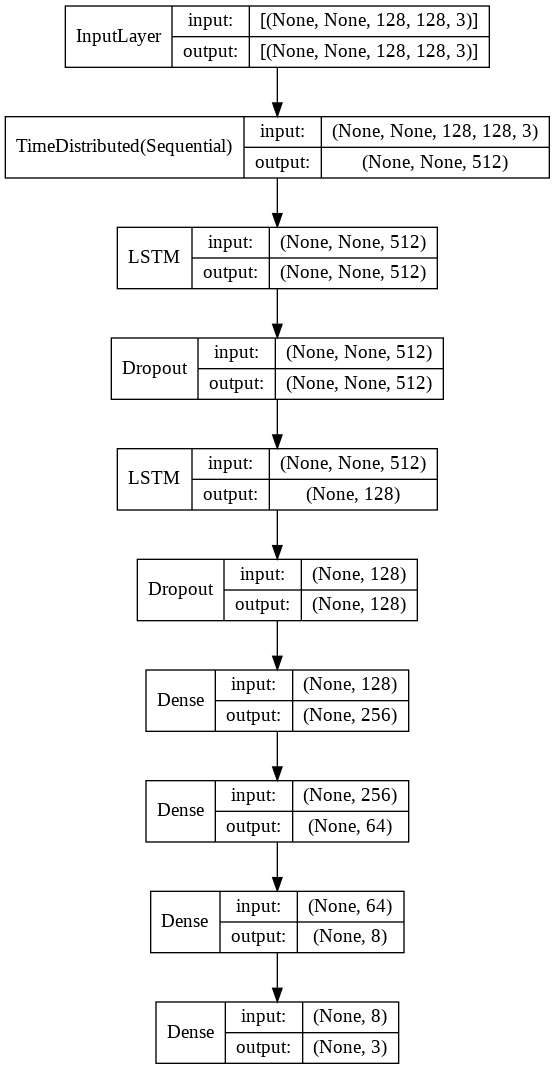

In [7]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(8, kernel_size=16, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size=16, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=16, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model2 = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.TimeDistributed(model, input_shape=(None,128,128,3)))
model2.add(tf.keras.layers.LSTM(512, return_sequences=True))
model2.add(Dropout(0.6))
model2.add(tf.keras.layers.LSTM(128, return_sequences=False))
model2.add(Dropout(0.6))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(3, activation='linear'))
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=False)

In [8]:
model2.compile(optimizer='rmsprop', loss='mse')

In [9]:
model.summary()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 8)       6152      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 32)        65568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                        

In [10]:
# Y_train = Y_train[3:1501,:]
print(X_train.shape, Y_train.shape)

(1250, 4, 128, 128, 3) (1250, 3)


In [11]:
history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=4, epochs=100)

Epoch 1/100
313/313 [==============================] - 23s 32ms/step - loss: 24.3603 - val_loss: 63.5729
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 19.7609 - val_loss: 45.7062
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 17.3405 - val_loss: 76.1866
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 14.2663 - val_loss: 64.0119
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 12.8810 - val_loss: 62.3254
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 11.6768 - val_loss: 65.6680
Epoch 7/100
313/313 [==============================] - 7s 24ms/step - loss: 9.8091 - val_loss: 60.4921
Epoch 8/100
313/313 [==============================] - 8s 25ms/step - loss: 8.4004 - val_loss: 71.1085
Epoch 9/100
313/313 [==============================] - 8s 24ms/step - loss: 8.3148 - val_loss: 66.3753
Epoch 10/100
313/313 [==============================] - 7s 24ms/st

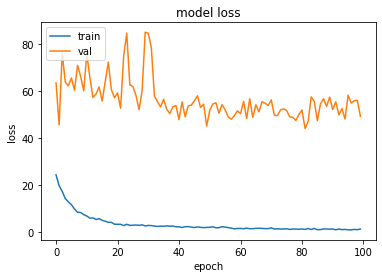

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [13]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [14]:
Y_pred = model2.predict(X_train)

40/40 [==============================] - 2s 20ms/step


In [15]:
print(Y_pred)

[[-0.89394677  4.540628    9.529217  ]
 [-0.6915138   4.572956    9.533149  ]
 [ 0.06099337  4.672105    9.60103   ]
 ...
 [17.136541   -0.18698719  8.984802  ]
 [16.998331   -0.24892506  8.933263  ]
 [ 6.4354434   3.414276   10.018631  ]]


In [16]:
print(Y_train[:,1].shape, Y_pred[:,1].shape)

(1250,) (1250,)


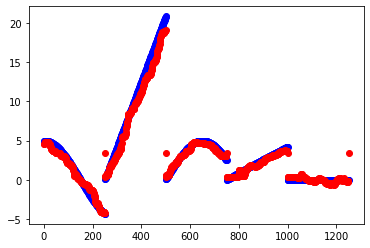

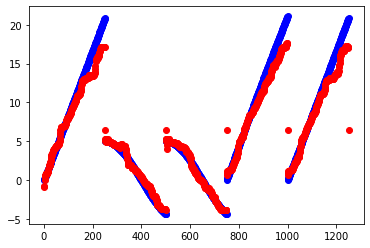

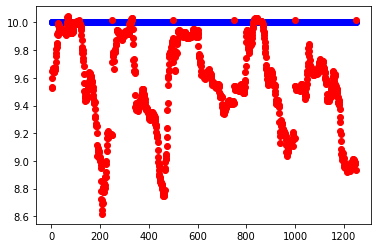

In [17]:
X_axis = range(1,1251)
plt.scatter(X_axis, Y_train[:,1], c ="blue")
plt.scatter(X_axis, Y_pred[:,1], c ="red")
plt.show()
plt.scatter(X_axis, Y_train[:,0], c ="blue")
plt.scatter(X_axis, Y_pred[:,0], c ="red")
plt.show()
plt.scatter(X_axis, Y_train[:,2], c ="blue")
plt.scatter(X_axis, Y_pred[:,2], c ="red")
plt.show()

40/40 [==============================] - 1s 22ms/step


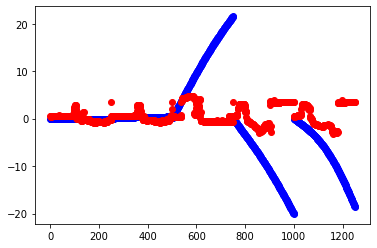

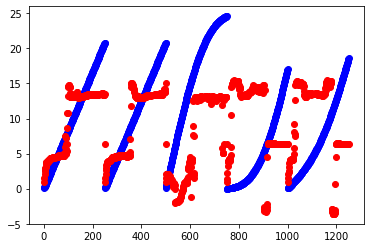

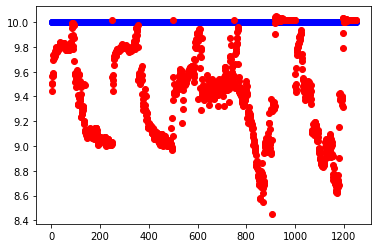

In [18]:
Y_pred = model2.predict(X_val)
X_axis = range(1,1251)
plt.scatter(X_axis, Y_val[:,1], c ="blue")
plt.scatter(X_axis, Y_pred[:,1], c ="red")
plt.show()
plt.scatter(X_axis, Y_val[:,0], c ="blue")
plt.scatter(X_axis, Y_pred[:,0], c ="red")
plt.show()
plt.scatter(X_axis, Y_val[:,2], c ="blue")
plt.scatter(X_axis, Y_pred[:,2], c ="red")
plt.show()